In [89]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


In [90]:
#import the csv file
oilPrices = pd.read_csv('CrudePrices.csv')
#change column names to more comfortable names
oilPrices.columns=['date', 'WTI', 'BRENT', 'BONNY']
#Cast Date Column to type date
oilPrices['date'] = pd.to_datetime(oilPrices['date'])
print("Data Set:"% oilPrices.columns, oilPrices.shape)
print("Data Types:", oilPrices.dtypes)
#Check the top five records
oilPrices.head()

Data Set: (1282, 4)
Data Types: date     datetime64[ns]
WTI             float64
BRENT           float64
BONNY           float64
dtype: object


,date,WTI,BRENT,BONNY
0,2015-11-23,39.27,43.70,45.120
1,2015-11-24,40.89,44.38,45.895
2,2015-11-25,41.22,43.56,45.240
3,2015-11-26,NaN,43.55,45.170
4,2015-11-27,40.57,43.07,44.885


In [91]:
oilPrices.set_index('date', inplace=True)
oilPrices = oilPrices.resample('D').ffill().reset_index()

In [92]:
oilPrices.set_index('date', inplace=True)
oilPrices = oilPrices.resample('D').ffill().reset_index()

In [93]:
oilPrices['year']=oilPrices['date'].dt.year
oilPrices['month']=oilPrices['date'].dt.month
oilPrices['week']=oilPrices['date'].dt.isocalendar().week

In [94]:
train = oilPrices[(oilPrices['date' ] > '2015-11-23') & (oilPrices['date' ] <= '2020-11-19')]
test = oilPrices[oilPrices['date' ] >= '2020-11-20']

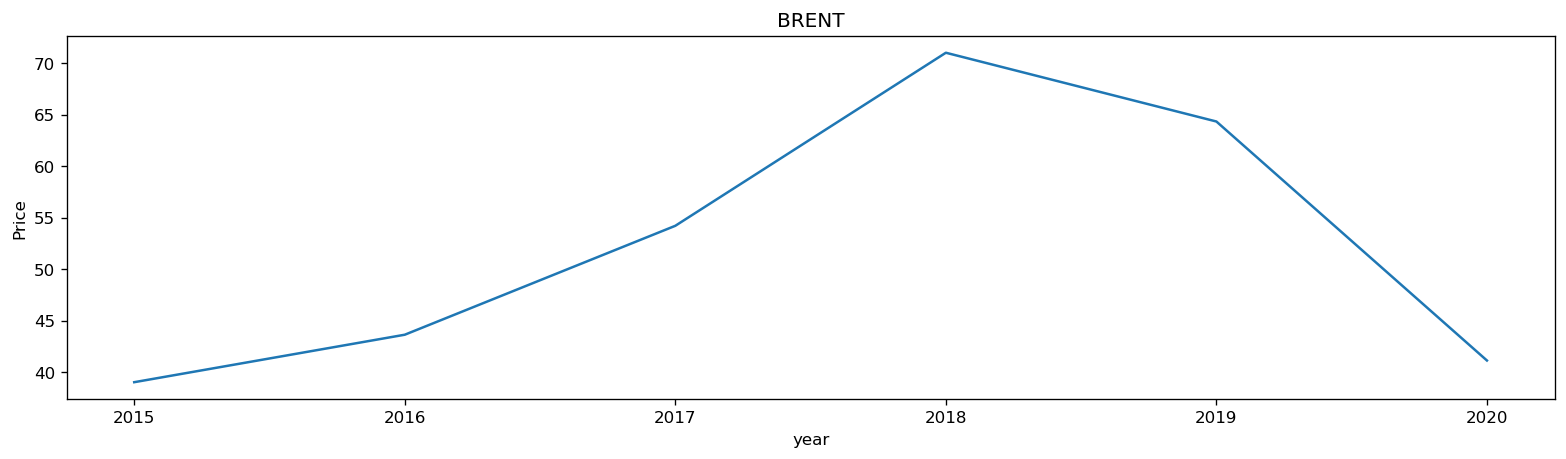

In [95]:
yearlyPrice=train.groupby(["year"])['BRENT'].mean()
plt.figure(figsize=(16,4))
plt.title('BRENT')
plt.xlabel('Year')
plt.ylabel('Price')
yearlyPrice.plot()
plt.show();

In [96]:
#Convert to Time Series For ARIMA Estimator
series=pd.Series(data=train['BRENT'].to_numpy(), index=train['date'])
series=series.dropna()

In [97]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.651517
p-value: 0.456249


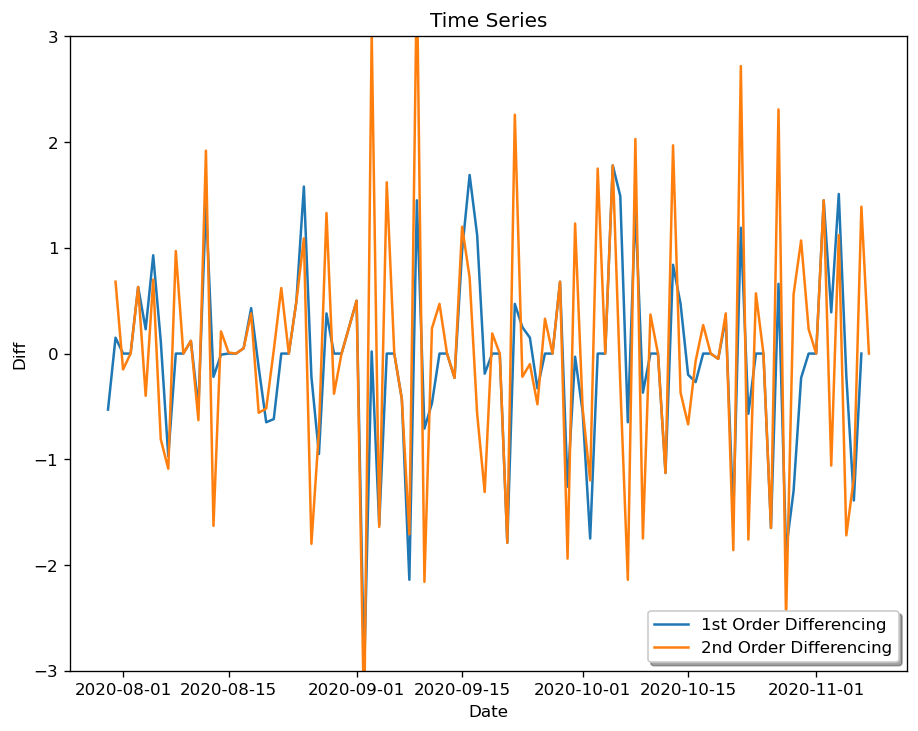

In [98]:
daily_series_diff1 = series.diff(periods=1).dropna()
daily_series_diff2 = daily_series_diff1.diff(periods=1).dropna()
fig, ax = plt.subplots()
ax.plot(daily_series_diff1[1700:1800], label='1st Order Differencing')
ax.plot(daily_series_diff2[1700:1800], label='2nd Order Differencing')
plt.ylim([-3,3])
legend = ax.legend(loc='lower right', shadow=True)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Diff')
plt.show()

In [99]:
#Number of differences required for a stationary series
from pmdarima.arima.utils import ndiffs
y=series.dropna()
# augmented Dickey–Fuller test (adf test)
print("ADF Test: ",ndiffs(y, test='adf'))
# Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
print("KPSS Test: ",ndiffs(y, test='kpss'))
# Phillips–Perron (PP) test:
print("PP Test: ",ndiffs(y, test='pp'))

ADF Test:  1
KPSS Test:  1
PP Test:  1


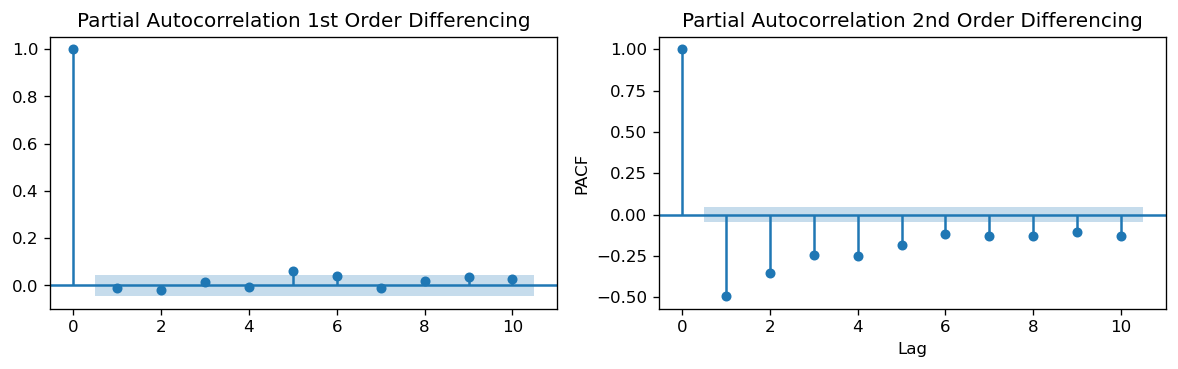

In [100]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_pacf(daily_series_diff1, lags=10, ax=axes[0], title="Partial Autocorrelation 1st Order Differencing")
plot_pacf(daily_series_diff2, lags=10, ax=axes[1], title="Partial Autocorrelation 2nd Order Differencing")
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

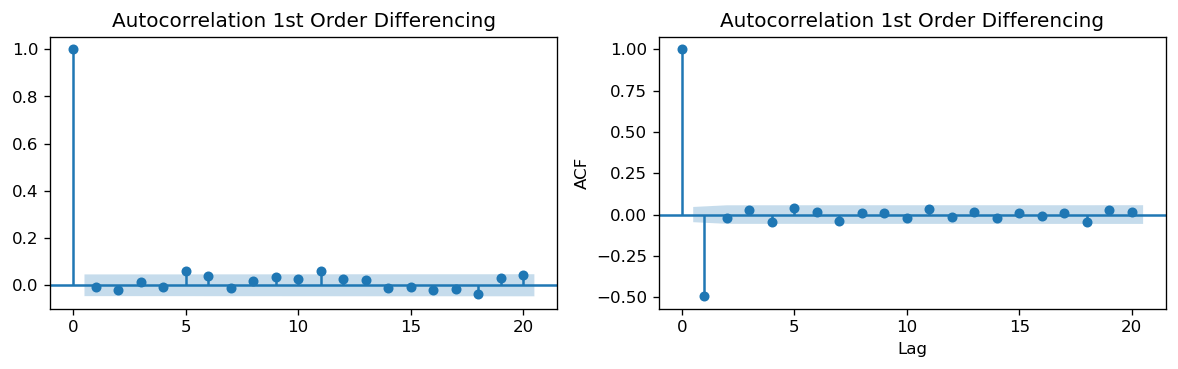

In [101]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(daily_series_diff1, lags=20, ax=axes[0], title="Autocorrelation 1st Order Differencing")
plot_acf(daily_series_diff2, lags=20, ax=axes[1], title="Autocorrelation 1st Order Differencing")
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [102]:
import pmdarima as pm
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5448.191, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5444.479, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5446.335, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5446.329, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5442.479, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.919 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1813
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2720.240
Date:                Wed, 20 Jan 2021   AIC                           5442.479
Time:                        03:44:40   BIC                           5447.981
Sample:                             0   HQIC                          5444.510
                               - 1813                                       

In [103]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(0, 1, 0)).fit(transparams=False)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1812
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2720.239
Method:                           css   S.D. of innovations              1.086
Date:                Wed, 20 Jan 2021   AIC                           5444.479
Time:                        03:44:40   BIC                           5455.483
Sample:                             1   HQIC                          5448.539
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.026     -0.028      0.978      -0.051       0.049


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [85]:
ARIMA_Predict = model.predict(start='1/1/2019', end='9/30/2020')

In [86]:
from fbprophet import Prophet
d={'ds':train['date'],'y':train['BRENT']}
df_pred=pd.DataFrame(data=d)
model = Prophet(daily_seasonality=False)
model.fit(df_pred)

<Figure size 1800x480 with 0 Axes>

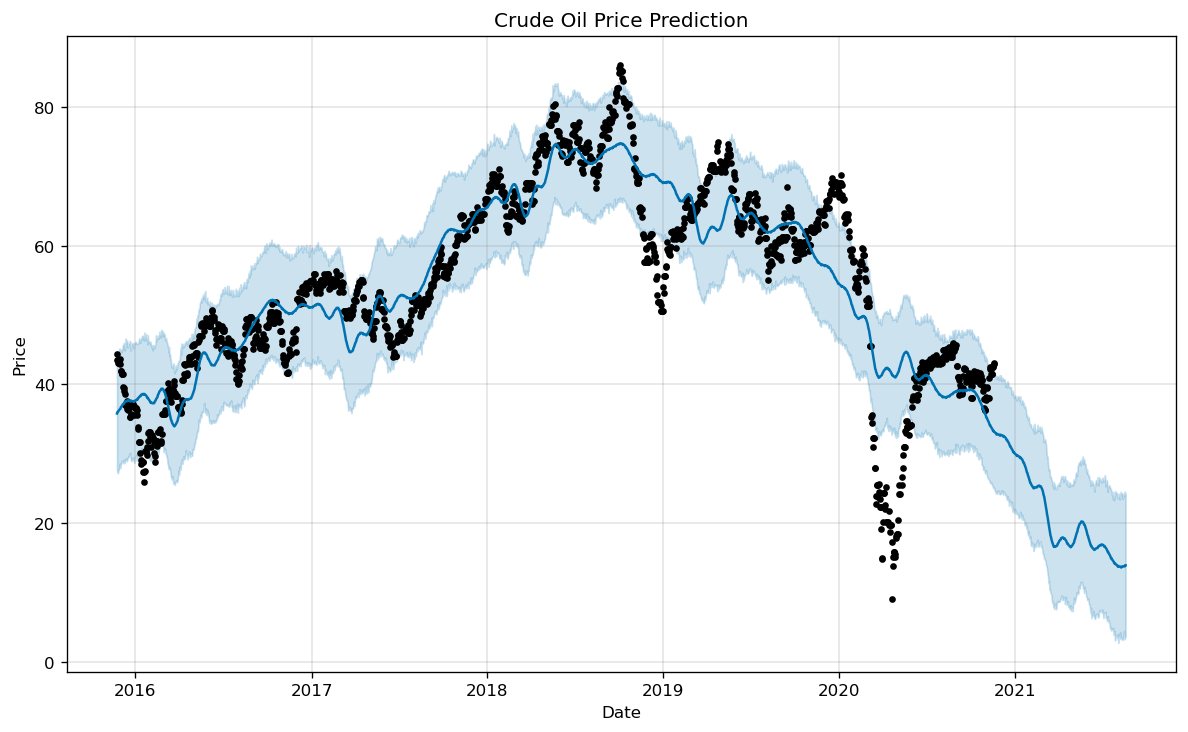

In [72]:
future = model.make_future_dataframe(periods=273)
forecast = model.predict(future)
plt.figure(figsize=(15, 4))
model.plot(forecast, xlabel = 'Date', ylabel = 'Price')
plt.title('Crude Oil Price Prediction');